# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import sys
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
sys.path.insert(0, '..')
from tqdm.notebook import tqdm
import seaborn as sns
import util.misc as utils
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    RNADatasetNT500,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    HFDataset,
    HFDataLoader, 
    create_augment_list,
    plot_sample,
    seed_everything,
)
from train_binary_cl import seed_worker, obtain_train_dataset, obtain_val_dataset, undersample_df, obtain_policies_object, obtain_dataset_object
from config import *

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
EASY_PRETRAINING = False
FINETUNING = False
TRAIN_HQ = False

scaling_factor = 5
min_n_groups_train = 5
max_n_groups_train = 80
min_n_groups_val = 80
max_n_groups_val = 80

# Esecuzione data loader train

In [83]:
if EASY_PRETRAINING:
    df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_easy.csv'))
    df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_easy.csv'))
    subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt_easy.txt")
else:
    if TRAIN_HQ:
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
        df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_HQ.csv'))
        subset_train_nt = os.path.join(rna_rna_files_dir, 'gene_pairs_training_nt_HQ.txt')
    else:
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
        df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))
        if FINETUNING:
            subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_train_val_fine_tuning_nt.txt")
        else:
            subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt.txt")

with open(subset_train_nt, "rb") as fp:  # Unpickling
    list_train = pickle.load(fp)

vc_train = df_nt[df_nt.couples.isin(list_train)].interacting.value_counts()
assert vc_train[False]>vc_train[True]
unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]

if EASY_PRETRAINING:
    pos_multipliers = {15:0.2, 
            25:0.3,
            50:0.2, 
            100:0.23, 
            10_000_000: 0.07}

    neg_multipliers = {15:0.05, 
                    28:0.15,

                    40:0.08,
                    50:0.05,
                    60:0.1,

                    80:0.03,
                    90:0.03,
                    100:0.05,

                    110:0.05,

                    120:0.1,

                    140:0.05,
                    160:0.03,
                    180:0.03,
                    200:0.03,
                    220:0.02,
                    240:0.01,
                    260:0.01,

                    10_000_000: 0.1}

else:
    pos_multipliers = {15:0.2, 
                   25:0.3,
                   50:0.2, 
                   100:0.23,
                   100_000_000:0.07}
    neg_multipliers = pos_multipliers

policies_train = [
    EasyPosAugment(
        per_sample=0.5,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalance_factor * 0.5,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
] 

dataset_train = RNADatasetNT(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file=subset_train_nt,
        augment_policies=policies_train,
        data_dir = os.path.join(embedding_dir, '32'),
        scaling_factor = scaling_factor,
        min_n_groups = min_n_groups_train,
        max_n_groups = max_n_groups_train,
)

In [84]:
np.sum(list(neg_multipliers.values()))

1.0

In [85]:
n_epochs = 3
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/86228 [00:00<?, ?it/s]

  0%|          | 0/86228 [00:00<?, ?it/s]

  0%|          | 0/86228 [00:00<?, ?it/s]

In [86]:
# plot_sample(sample, plot_interaction_negatives=True)

In [87]:
df_len.label.value_counts()

n    259062
p    258306
Name: label, dtype: int64

In [88]:
df_len.sort_values('length').head(500).label.value_counts()

n    296
p    204
Name: label, dtype: int64

In [89]:
(float(df_len.sort_values('length').quantile(0.2))/6)/80

0.84375

In [90]:
(float(df_len.sort_values('length').quantile(0.5))/6)/80

1.6666666666666667

In [91]:
#balance set
assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

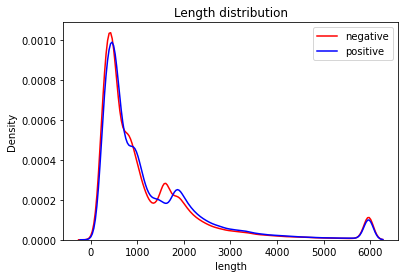

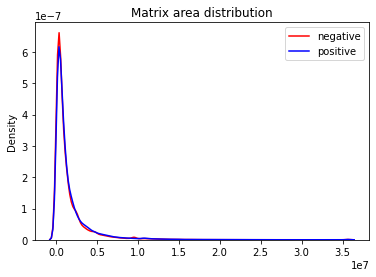

In [92]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

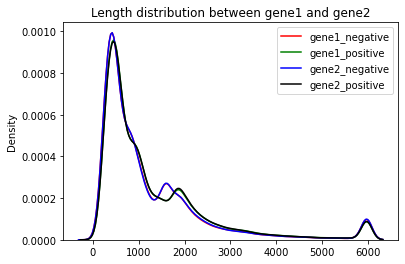

In [93]:
sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

In [94]:
small_l = df_len.length.quantile(0.1)
print(df_len[df_len['length'] < small_l].label.value_counts())
print('\n')
big_l = df_len.length.quantile(0.7)
print(df_len[df_len['length'] > big_l].label.value_counts())

n    27161
p    22026
Name: label, dtype: int64


p    78233
n    76964
Name: label, dtype: int64


In [95]:
# dataset_train = RNADatasetNT(
#     gene2info=df_genes_nt,
#     interactions=df_nt,
#     subset_file=subset_train_nt,
#     augment_policies=policies_train,
#     data_dir = os.path.join(embedding_dir, '32'),
# )

# all_couples = set(df_nt.couples_id)

# augment_list = create_augment_list(dataset_train, all_couples)

# dataset_train = HFDataset(augment_list)

# batch_size = 32

# sampler_train = torch.utils.data.RandomSampler(dataset_train)

# data_loader_train = HFDataLoader(dataset_train, batch_size=batch_size, 
#                                  sampler=sampler_train, drop_last=False,
#                                  collate_fn = utils.collate_fn_hf, num_workers=10)

# start_time = time.time()

# i = 0
# for s, targets in tqdm(data_loader_train):
#     i += 1
#     if i == 100:
#         break
    
# end_time = time.time()

# print('min:', (end_time-start_time)/60)

In [18]:
# policies = [
#     EasyPosAugment(
#         per_sample=1,
#         interaction_selection=InteractionSelectionPolicy.LARGEST,
#         width_multipliers=pos_multipliers,
#         height_multipliers=pos_multipliers,
#     ),  
#     SmartNegAugment(
#         per_sample=unbalance_factor,
#         interaction_selection=InteractionSelectionPolicy.LARGEST,
#         width_multipliers=neg_multipliers,
#         height_multipliers=neg_multipliers,
#     ),
# ]
  

# dataset_train = RNADatasetNT(
#     gene2info=df_genes_nt,
#     interactions=df_nt,
#     subset_file=subset_train_nt,
#     augment_policies=policies,
#     data_dir = os.path.join(embedding_dir, '32'),
# )

# sampler_train = torch.utils.data.RandomSampler(dataset_train)

# data_loader_train = DataLoader(dataset_train, 32,
#                              sampler=sampler_train, drop_last=False,
#                              collate_fn=utils.collate_fn_nt,
#                              num_workers=2,)

# start_time = time.time()

# i = 0
# for s, targets in tqdm(data_loader_train, total = len(data_loader_train)):
#     i += 1
#     if i == 100:
#         break
    
# end_time = time.time()

# print('min:', (end_time-start_time)/60)

# Validation set 

In [58]:
EASY_PRETRAINING = True

In [59]:
if EASY_PRETRAINING:
    df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_easy.csv'))
    df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_easy.csv'))
    subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_val_sampled_nt_easy.txt")
else:
    df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
    df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_HQ.csv'))
    if FINETUNING:
        subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_test_sampled_nt_HQ.txt") # gene_pairs_test_sampled_nt.txt it is also HQ
        df500 = pd.read_csv(os.path.join(metadata_dir, f'test500.csv'))
    else:
        subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_val_sampled_nt_HQ.txt") # gene_pairs_val_sampled_nt.txt it is also HQ
        df500 = pd.read_csv(os.path.join(metadata_dir, f'val500.csv'))

    with open(subset_val_nt, "rb") as fp:  # Unpickling
        list_val = pickle.load(fp)

    assert df500.shape[0] == df_nt[['couples', 'interacting', 'policy']].merge(df500, on = 'couples').shape[0]
    df500 = df_nt[['couples', 'interacting', 'policy']].merge(df500, on = 'couples')
    df500 = df500[df500.couples.isin(list_val)] # in questo modo ho quasi bilanciato del tutto, ma per avere un bilanciamento al 100% devo fare undersampling
    df500 = undersample_df(df500) #bilanciamento al 100%.

if EASY_PRETRAINING:
    pos_multipliers = {25:0.7, 50:0.2, 100:0.1}
    neg_multipliers = {33:0.3, 45:0.1, 55:0.1, 65:0.1,
                       80:0.05, 90:0.05, 100:0.05,
                       120:0.05, 150:0.02, 160:0.02,
                       170:0.02, 180:0.02, 190:0.02,
                       200:0.02, 210:0.02, 220:0.02}

    policies_val = [
        EasyPosAugment(
            per_sample=1,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_multipliers,
            height_multipliers=pos_multipliers,
        ),  
        SmartNegAugment(
            per_sample=1, # unbalance_factor
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=neg_multipliers,
            height_multipliers=neg_multipliers,
        ),
    ]

    dataset_val = RNADatasetNT(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file=subset_val_nt,
        augment_policies=policies_val,
        data_dir = os.path.join(embedding_dir, '32'),
        scaling_factor = scaling_factor,
        min_n_groups = min_n_groups_val,
        max_n_groups = max_n_groups_val,
    )

else:

    df500 = df500.sample(frac=1, random_state=23).reset_index(drop = True)
    assert df500.shape[0]>0

    dataset_val = RNADatasetNT500(
        df = df500,
        data_dir = os.path.join(embedding_dir, '32'),
        scaling_factor = scaling_factor,
        min_n_groups = min_n_groups_val,
        max_n_groups = max_n_groups_val,
    )
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

In [60]:
np.sum(list(neg_multipliers.values()))

0.9600000000000001

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/36996 [00:00<?, ?it/s]

  0%|          | 0/36996 [00:00<?, ?it/s]

  0%|          | 0/36996 [00:00<?, ?it/s]

median: 700.0


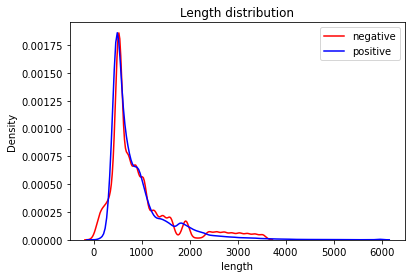

In [61]:
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_val, total=len(dataset_val)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

print('median:', df_len.length.median())

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()

# Esecuzione data loader external dataset

In [115]:
dataset = 'ricseq'

df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{dataset}.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{dataset}.csv'))
data_dir = os.path.join(rna_rna_files_dir, f'{dataset}')
file_training = os.path.join(data_dir, 'gene_pairs_training.txt')
with open(file_training, "rb") as fp:   # Unpickling
    train_couples = pickle.load(fp)

    
file_test = os.path.join(data_dir, 'gene_pairs_test.txt')
with open(file_test, "rb") as fp:   # Unpickling
    test_couples = pickle.load(fp)
    
train_nt = df_nt[df_nt.couples_id.isin(train_couples)]
test_nt = df_nt[df_nt.couples_id.isin(test_couples)]

In [116]:
df_nt.interacting.value_counts()

False    17124
True     13315
Name: interacting, dtype: int64

In [117]:
train_nt.interacting.value_counts()

False    12048
True      9317
Name: interacting, dtype: int64

In [118]:
test_nt.interacting.value_counts()

False    5095
True     3998
Name: interacting, dtype: int64

In [131]:
scaling_factor = 5

if dataset == 'splash':
    pos_multipliers = {5:0.7, 15:0.2, 50:0.1, 100:0.1}
    neg_multipliers = {5:0.7, 15:0.2, 50:0.1, 100:0.1}

elif dataset == 'mario':
    pos_multipliers = {5:0.7, 15:0.2, 50:0.1, 100:0.1}
    neg_multipliers = {5:0.1, 6:0.5, 15:0.2, 50:0.13, 100:0.13}

elif dataset == 'ricseq':
    pos_multipliers = {5:0.7, 25:0.1, 70:0.1, 100:0.1}
    neg_multipliers = {5:0.02, 10:0.85, 
                       70:0.02, 80:0.02, 90:0.02,
                       100:0.2}

vc_train = train_nt.interacting.value_counts()
if vc_train[False]>vc_train[True]:
    unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]
    policies_train = obtain_policies_object(0.25, 0.25*unbalance_factor, pos_multipliers, neg_multipliers)
elif vc_train[False]<vc_train[True]:
    unbalance_factor = 1 - (vc_train[True] - vc_train[False]) / vc_train[True]
    policies_train = obtain_policies_object(0.25*unbalance_factor, 0.25, pos_multipliers, neg_multipliers)
elif vc_train[True]==vc_train[True]:
    unbalance_factor = 1

dataset_train  = obtain_dataset_object(policies_train, df_genes_nt, df_nt, '', scaling_factor, min_n_groups_train, max_n_groups_train)

In [132]:
n_epochs = 10
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

In [133]:
df_len.label.value_counts()

n    66940
p    65460
Name: label, dtype: int64

In [134]:
df_len.sort_values('length').head(500).label.value_counts()

n    294
p    206
Name: label, dtype: int64

In [135]:
#balance set
assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

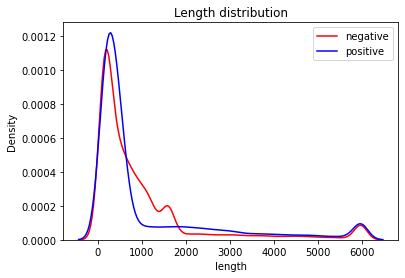

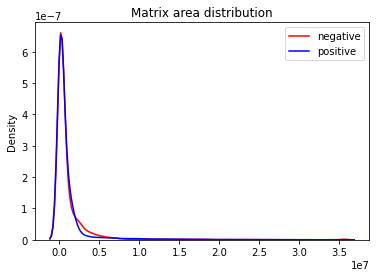

In [136]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

### Validation

In [170]:
dataset = 'mario'

In [150]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{dataset}.csv'))
data_dir = os.path.join(rna_rna_files_dir, f'{dataset}')

file_test = os.path.join(data_dir, 'gene_pairs_test.txt')
with open(file_test, "rb") as fp:   # Unpickling
    test_couples = pickle.load(fp)

df500 = pd.read_csv(os.path.join(metadata_dir, f'{dataset}500.csv'))
assert df500.shape[0] == df_nt[['couples', 'couples_id', 'interacting', 'policy']].merge(df500, on = 'couples').shape[0]
df500 = df_nt[['couples', 'interacting', 'policy', 'couples_id']].merge(df500, on = 'couples')
df500 = df500[df500.couples_id.isin(test_couples)]
df500 = df500[df500.policy.isin(['easypos', 'smartneg'])]
df500 = undersample_df(df500)

df500 = df500.sample(frac=1, random_state=23).reset_index(drop = True)
assert df500.shape[0]>0

dataset_val = RNADatasetNT500(
    df = df500,
    data_dir = os.path.join(embedding_dir, '32'),
    scaling_factor = scaling_factor,
    min_n_groups = min_n_groups_val,
    max_n_groups = max_n_groups_val,
)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

median: 500.0


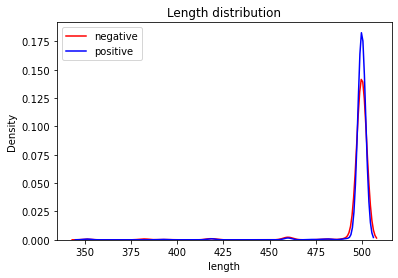

In [151]:
n_epochs = 10
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_val, total=len(dataset_val)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

print('median:', df_len.length.median())

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()